Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_validate
from sklearn.metrics import matthews_corrcoef, f1_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import mode
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline, make_pipeline

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

Load Data

In [2]:
train_df = pd.read_csv("data/playground-series-s4e8/train.csv", index_col='id')
orig_df = pd.read_csv("data/secondary-mushroom-dataset-data-set/MushroomDataset/secondary_data.csv", sep=";")
test_df = pd.read_csv("data/playground-series-s4e8/test.csv", index_col='id')
train_df = pd.concat([train_df, orig_df], ignore_index=True) # Combine the competition data with the secondary data

Pre-process Data

In [3]:
# Remove Duplicates
train_df.drop_duplicates(inplace=True)

# Categorize Features
target = 'class'
features = train_df.drop(target, axis=1).columns.to_list()
features_with_high_null_values = [feature for feature in features if (train_df[feature].isna().sum()/len(train_df)*100)>20]
categorical_features = train_df[features].select_dtypes(include='object').columns.to_list()
numerical_features = list(set(features) - set(categorical_features))

In [4]:
''' Impute Missing Values (Null Values) '''

# Clean Categorical Features
def cleaner(df):
    for col in categorical_features:
        df[col] = df[col].fillna('missing')
        df.loc[df[col].value_counts(dropna=False)[df[col]].values < 100, col] = "noise"
        df[col] = df[col].astype('category')

    return df

train_df = cleaner(train_df)
test_df = cleaner(test_df)

# Clean Numerical Features with mean
cap_diameter_mean = pd.concat([train_df['cap-diameter'], test_df['cap-diameter']]).mean(numeric_only=True)
train_df['cap-diameter'].fillna(cap_diameter_mean, inplace=True)
test_df['cap-diameter'].fillna(cap_diameter_mean, inplace=True)

In [5]:
X = train_df.copy()
y = X.pop(target)

lab_enc = LabelEncoder().fit(y)
y = lab_enc.transform(y)

Prepare Training

In [6]:
def model_report(estimator, X, y, cv=5):
    print("="*80)
    print(f"    Model: {estimator.__class__.__name__}")
    print("="*80)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1/cv, shuffle=True, stratify=y, random_state=42)
    
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"F1 Score : {f1.mean():.6f}")
    print(f"MCC Score: {mcc.mean():.6f}")
    
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title("Confusion Matrix")
    plt.show()

    print()

In [7]:
def model_trainer(model, X, y, test_set, skfold, random_state=42):
    print("="*80)
    print(f"Training {model.__class__.__name__}")
    print("="*80, end="\n")

    oof_mccs = []
    test_probs = np.zeros((test_set.shape[0],))   # test set probabilities. Average of each fold's probability prediction on test set.
    oof_probs = np.zeros((X.shape[0],))   # training set probabilities

    for fold, (train_idx, val_idx) in enumerate(skfold.split(X, y)):
        # Select train, validation set by each fold
        X_train, y_train = X.iloc[train_idx, :], y[train_idx]
        X_val, y_val = X.iloc[val_idx, :], y[val_idx]

        # Train Model
        model = clone(model)
        model.fit(X_train, y_train)

        # Evaluate by validation set
        val_probs = model.predict_proba(X_val)[:, 1]   # Calculate probability
        oof_probs[val_idx] = val_probs   # Save probability of this fold's validation set
        val_preds = (val_probs > 0.5).astype(int)   # Convert probability to label
        mcc = matthews_corrcoef(y_val, val_preds)   # Calculate mcc score
        oof_mccs.append(mcc)   # Save mcc score of this fold's validation set
        print(f"--- Fold {fold+1} MCC Score: {mcc:.6f}")

        # Predict on test set
        test_probs += model.predict_proba(test_set)[:, 1] / skfold.get_n_splits()   # Aggregate test set probabilities

    mean_mcc_score = np.mean(oof_mccs)
    std_mcc_score = np.std(oof_mccs)
    print(f"\n---> Mean MCC Score: {mean_mcc_score:.6f} \xb1 {std_mcc_score:.6f}\n\n")
    
    total_mcc_score = matthews_corrcoef(y, (oof_probs > 0.5).astype(int))
    print(f"Total MCC Score: {total_mcc_score:.6f}")

    return oof_mccs, test_probs, oof_probs

Baseline Models

In [8]:
xgb_clf = XGBClassifier(enable_categorical=True, device="cuda", tree_method="hist")
cat_clf = CatBoostClassifier(
    cat_features=categorical_features,
    verbose=False,
    allow_writing_files=False,
    task_type="GPU"
)
lgb_clf = LGBMClassifier(device='gpu', verbosity=-1)

Hyper Parameters

In [14]:
xgb_params = {
    'n_estimators': 2407,
    'eta': 0.009462133032592785,
    'gamma': 0.2865859948765318,
    'max_depth': 31,
    'min_child_weight': 47,
    'subsample': 0.6956431754146083,
    'colsample_bytree': 0.3670732604094118,
    'grow_policy': 'lossguide',
    'max_leaves': 73,
    'enable_categorical': True,
    'n_jobs': -1,
    'device': 'cuda',
    'tree_method': 'hist'
} # 0.9844272567086021

cat_params = {
    'iterations': 1041,
    'learning_rate': 0.08777255350163136,
    'depth': 10,
    'l2_leaf_reg': 0.1259643500248322,
    'bootstrap_type': 'Bayesian',
    'random_strength': 4.276181166674371e-08,
    'bagging_temperature': 0.35995482350907326,
    'od_type': 'Iter',
    'od_wait': 39,
    "verbose": False,
    "allow_writing_files": False,
    "task_type": 'GPU',
    "cat_features": categorical_features
} # 0.9841773055825763

lgb_params = {
    'n_estimators': 2500,
    'random_state':42,
    'max_bin':1024,
    'colsample_bytree':0.6,
    'reg_lambda': 80,
    # 'device': 'gpu',
    'verbosity': -1
}

Train Base Model

In [10]:
# %% time
cv_summary, test_probs, oof_probs = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
random_state = 101
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

In [11]:
cv_summary['xgb'], test_probs['xgb'], oof_probs['xgb'] = model_trainer(XGBClassifier(**xgb_params), X, y, test_df, skfold, random_state=random_state)

Training XGBClassifier
--- Fold 1 MCC Score: 0.984879
--- Fold 2 MCC Score: 0.984927
--- Fold 3 MCC Score: 0.984749
--- Fold 4 MCC Score: 0.984930
--- Fold 5 MCC Score: 0.984882

---> Mean MCC Score: 0.984873 ± 0.000066


Total MCC Score: 0.984873


In [12]:
cv_summary['cat'], test_probs['cat'], oof_probs['cat'] = model_trainer(CatBoostClassifier(**cat_params), X, y, test_df, skfold, random_state=random_state)

Training CatBoostClassifier
--- Fold 1 MCC Score: 0.984758
--- Fold 2 MCC Score: 0.984882
--- Fold 3 MCC Score: 0.984603
--- Fold 4 MCC Score: 0.984701
--- Fold 5 MCC Score: 0.984780

---> Mean MCC Score: 0.984745 ± 0.000092


Total MCC Score: 0.984745


In [15]:

cv_summary['lgb'], test_probs['lgb'], oof_probs['lgb'] = model_trainer(LGBMClassifier(**lgb_params), X, y, test_df, skfold, random_state=random_state)

Training LGBMClassifier
--- Fold 1 MCC Score: 0.985025
--- Fold 2 MCC Score: 0.984989
--- Fold 3 MCC Score: 0.984879
--- Fold 4 MCC Score: 0.984977
--- Fold 5 MCC Score: 0.984971

---> Mean MCC Score: 0.984968 ± 0.000048


Total MCC Score: 0.984968


In [16]:
# Performance Summary for comparing model (Not Needed)
transposed_df = cv_summary.transpose()
transposed_df.columns = ['fold1','fold2','fold3','fold4','fold5']
transposed_df['Mean'] = transposed_df.mean(axis=1)
transposed_df['Std'] = transposed_df.std(axis=1)
transposed_df.sort_values(by = 'Mean', ascending=False).style.background_gradient('Dark2_r')

,fold1,fold2,fold3,fold4,fold5,Mean,Std
lgb,0.985025,0.984989,0.984879,0.984977,0.984971,0.984968,0.000048
xgb,0.984879,0.984927,0.984749,0.984930,0.984882,0.984873,0.000066
cat,0.984758,0.984882,0.984603,0.984701,0.984780,0.984745,0.000092


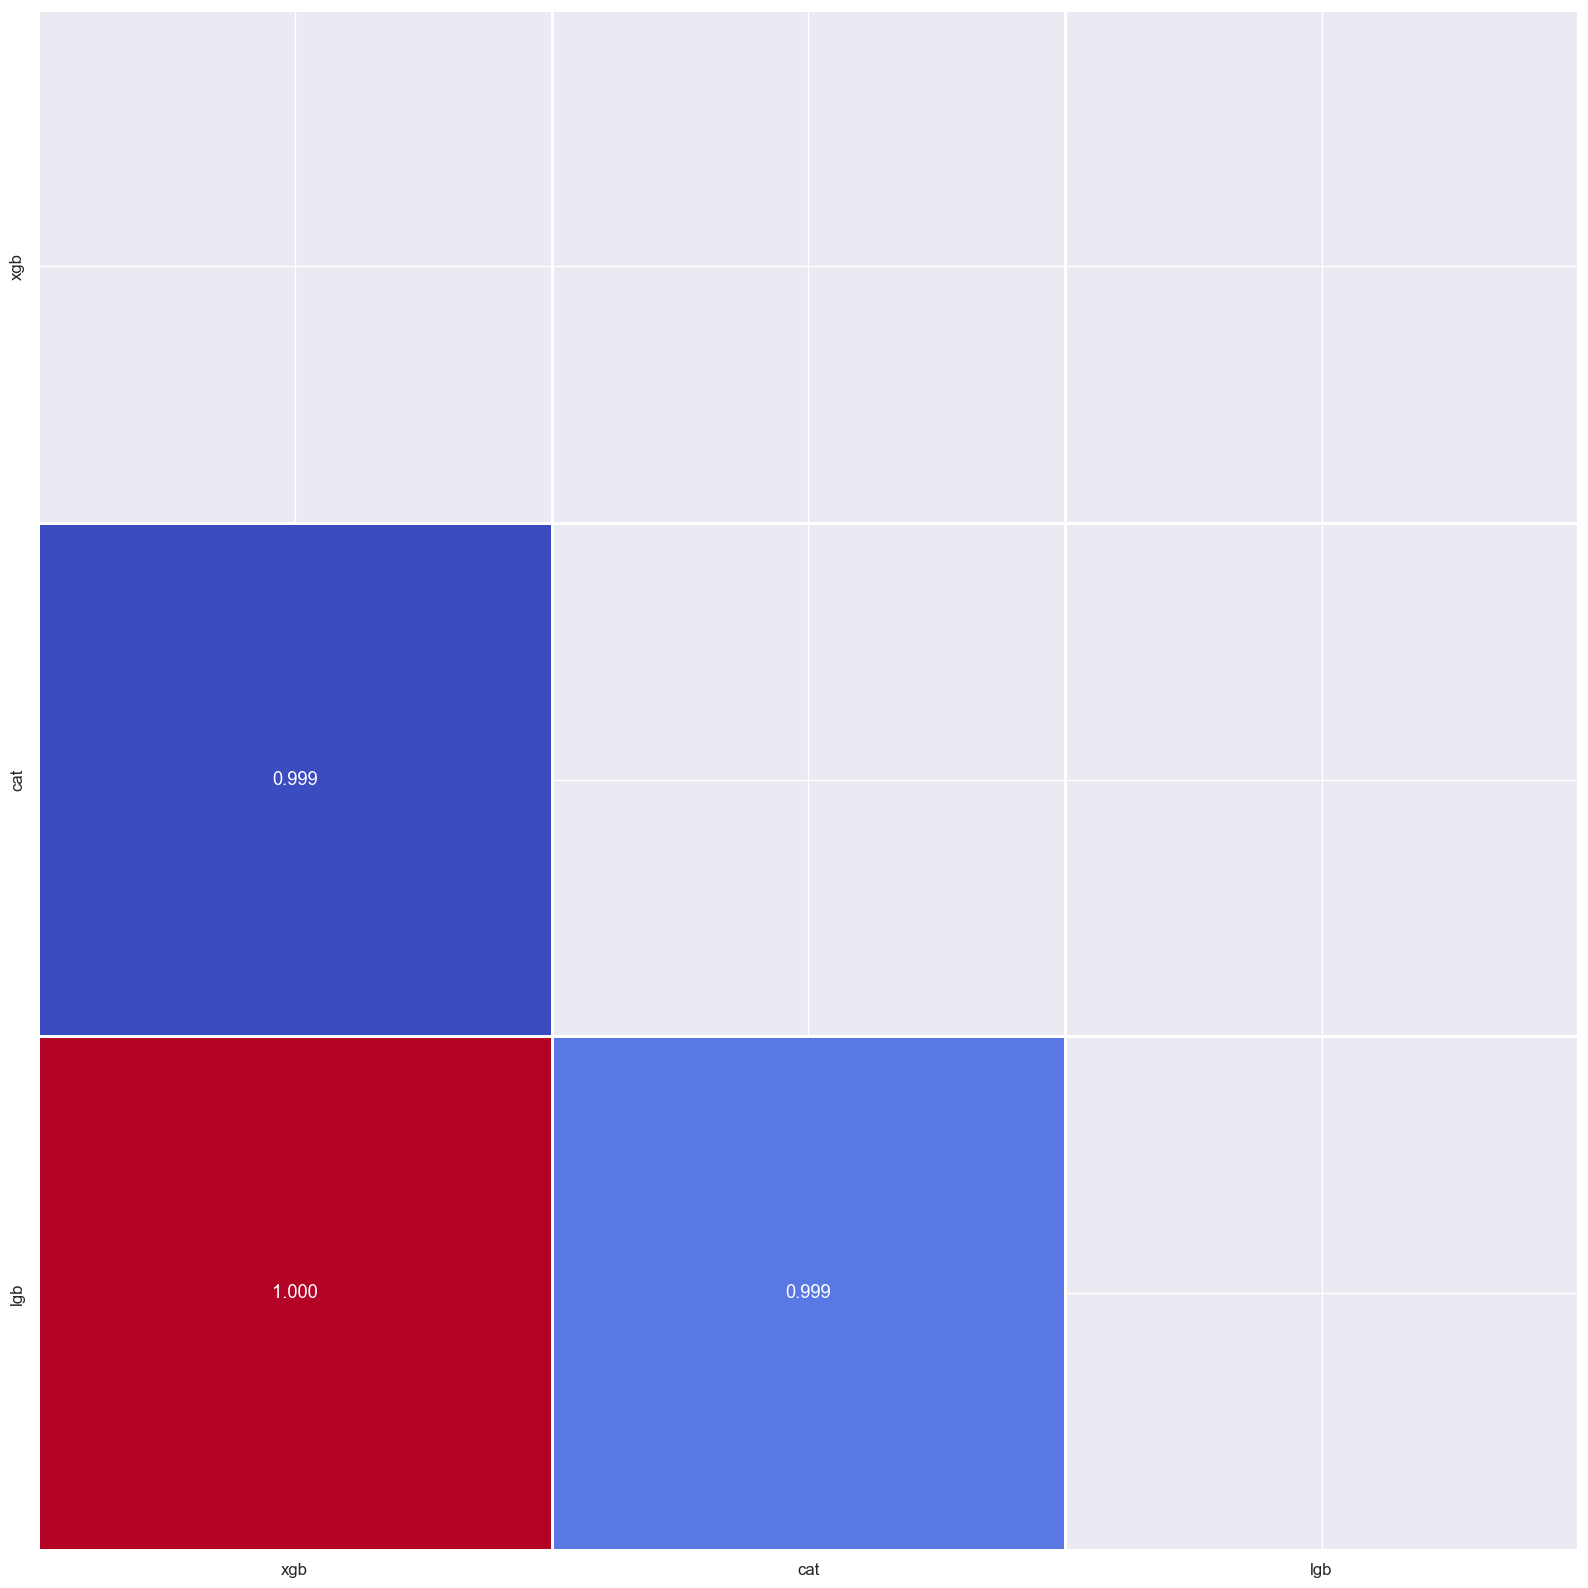

In [17]:
# Model diversity check (Not Needed)
sns.set(font_scale=1.1)
correlation_train = oof_probs.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.3f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False);

### Ensemble

1. Voting

In [18]:
#voting hard & soft
def voting_ensemble(oof_probs, y, threshold=0.5, voting_type='soft'):
    if voting_type == 'soft':
        ensemble_preds = oof_probs.mean(axis=1)
        ensemble_class_preds = (ensemble_preds > threshold).astype(int)
        
    elif voting_type == 'hard':
        binary_preds = (oof_probs > threshold).astype(int)
        ensemble_class_preds = mode(binary_preds, axis=1)[0].flatten()
    
    mcc_score = matthews_corrcoef(y, ensemble_class_preds)
    
    return mcc_score

In [19]:
voting_ensemble(oof_probs, y, voting_type='soft')

0.9851030236071956

In [20]:
voting_ensemble(oof_probs, y, voting_type='hard')

0.9850718579602097

2. Stacking

In [21]:
#parameters for meta model                                                                                                 
meta_model_params = {
    'C': 0.000237302749626327,
    'max_iter': 2500,
    'tol': 9.996751434702547e-05,
    'solver': 'saga',
    'penalty': 'l1'
}

meta_model = LogisticRegression(**meta_model_params, random_state=random_state)

In [22]:
# %%time

#Deciding which models to include ensemble

min_features_to_select = 1

# Create a pipeline with preprocessor and RFECV
pipeline = Pipeline([
    ('Scaler', StandardScaler()),
    ('rfecv', RFECV(estimator=meta_model,
                    step=1,
                    cv=skfold,
                    scoring=make_scorer(matthews_corrcoef),
                    min_features_to_select=min_features_to_select,
                    n_jobs=-1,))
])

# Fit the pipeline on oof_preds
pipeline.fit(oof_probs, y)

#CV score
print("Best CV score: ")
selected_models = np.array(oof_probs.columns)[pipeline.named_steps['rfecv'].support_]
print( pipeline.named_steps['rfecv'].cv_results_["mean_test_score"][len(selected_models) - 1])


# Selected models after RFECV
print('Number of available models:', len(oof_probs.columns))
print('Number of selected models for ensemble:', len(selected_models))
print("Selected models:", selected_models)

Best CV score: 
0.98506661475708
Number of available models: 3
Number of selected models for ensemble: 3
Selected models: ['xgb' 'cat' 'lgb']


In [ ]:
meta_model = meta_model.fit(oof_probs[selected_models], y)
preds_test =  meta_model.predict(test_probs[selected_models])
le = LabelEncoder()
preds_test = le.inverse_transform(preds_test)

Submission

In [ ]:
output = pd.DataFrame({'id': test_df.index,
                       'class': preds_test})
output.to_csv('submission.csv', index=False)

In [ ]:
output.head()

In [ ]:
#save oofs and test predictions for later usage
oof_probs.to_parquet('oof_predictions_v01.parquet', index=False)
test_probs.to_parquet('test_predictions_v01.parquet', index=False)

In [ ]:
# sub = pd.read_csv("/data/playground-series-s4e8/sample_submission.csv")
# preds = [pred for model, pred in oof_preds.items()]
# md = mode(preds, axis=0)[0] if len(preds)>1 else preds[0]
# sub[target] = lab_enc.inverse_transform(md)
# sub.to_csv("submission.csv", index=False)

In [ ]:
# ext1 = pd.read_csv("/kaggle/input/mario-s-nightmare-15-th-place-solution/submission.csv")[target].ravel()
# ext2 = pd.read_csv("/kaggle/input/ps4e8-binary-class-mathews-correlation-coeff/submission.csv")[target].ravel()
# ext3 = pd.read_csv("/kaggle/input/playgrounds4e08-modeblend/submission.csv")[target].ravel()
# ext4 = pd.read_csv("/kaggle/input/autogloun-t8-dslanders/submission.csv")[target].ravel()
# ext5 = pd.read_csv("/kaggle/input/mario-s-nightmare-denselight-0-990/submission_test7.csv")[target].ravel()

# preds = [ext1, ext2, ext3, ext4, ext5]
# preds = [lab_enc.transform(x) for x in preds]
# md = mode(preds, axis=0)[0]
# sub[target] = lab_enc.inverse_transform(md)
# sub.to_csv("submission.csv", index=False)